<a href="https://colab.research.google.com/github/Seungwon-hub/ESAA/blob/main/ESAA_OB_Week2_Ensemble_RandomForest_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os


# 5장에서의 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 7.5 부스팅

부스팅은 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법이다. 부스팅의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것이다.

### 7.5.1 에이다부스트

이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이는 것이다. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 되는데, 이것이 에이다부스트에서 사용하는 방식이다.

예를 들어 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 번째 분류기를 훈련 세트에서 훈련시키고 예측을 만든다. 그 다음 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높인다. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만든다. 그 다음에 다시 가중치를 업데이트하는 식으로 계속된다.

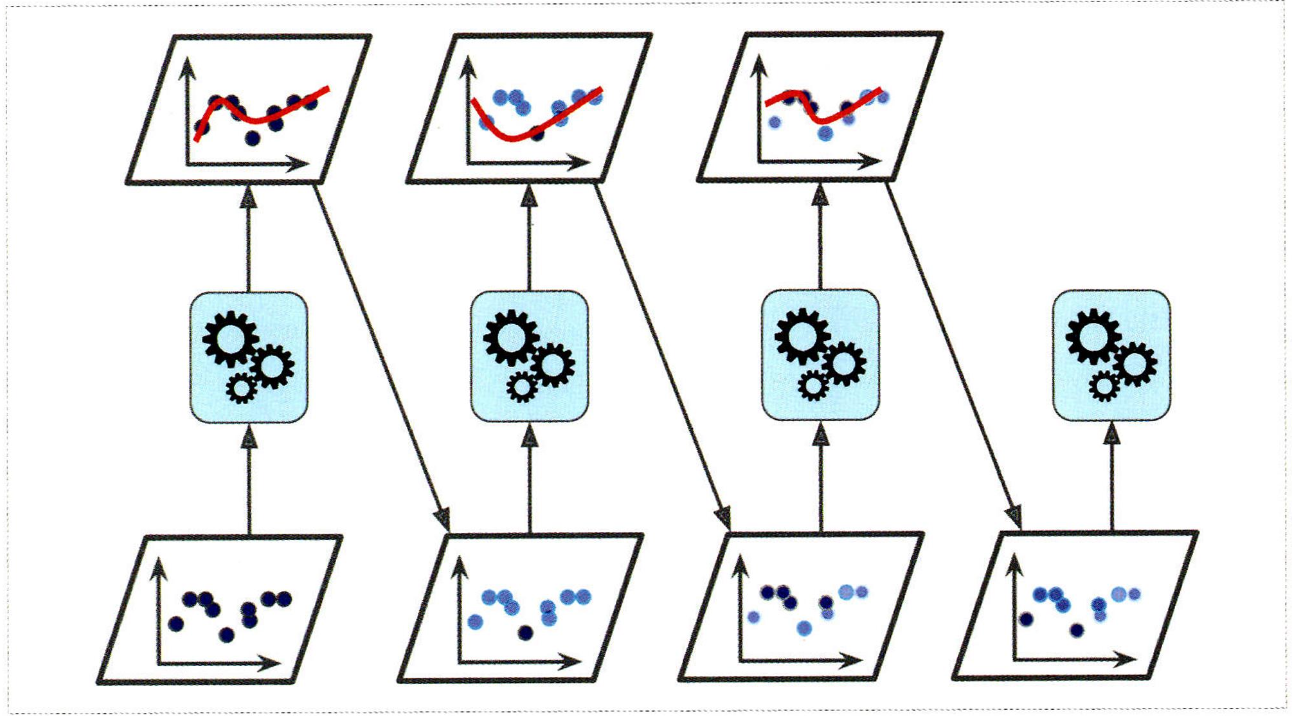

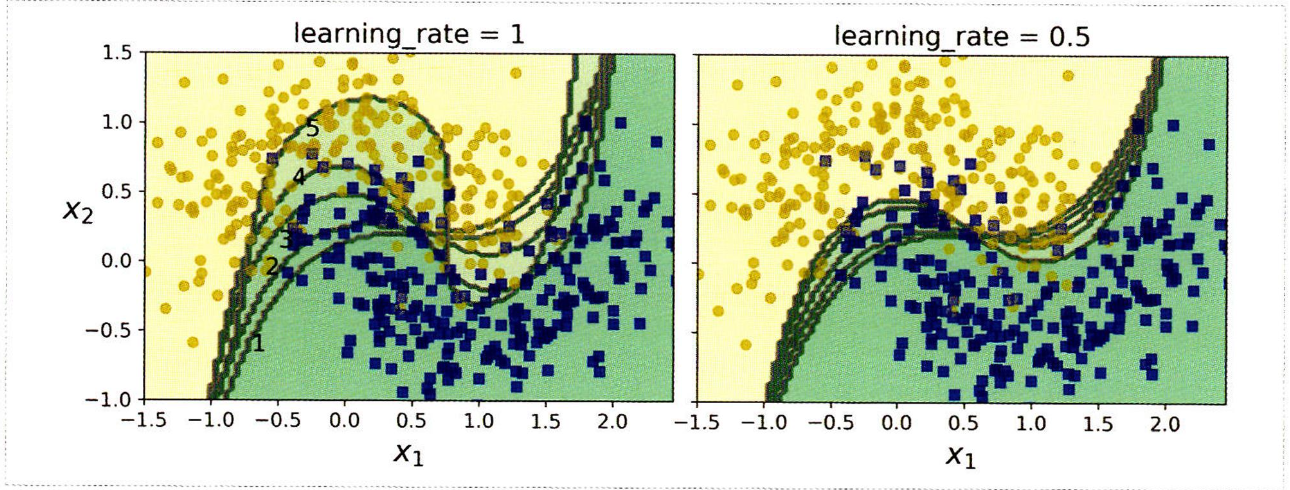

이 그림은 moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계다. 이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기다. 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다. 따라서 두 번째 분류기는 이 샘플들을 더 정확하게 예측하게 된다. 오른쪽 그래프는 학습률을 반으로 낮춘 것 빼고 똑같은 일련의 예측기를 나타낸 것이다. 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있다. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가고 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.

<에이다부스트 알고리즘>
각 샘플 가중치 w는 초기에 1/m로 초기화된다. 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 r이 훈련 세트에 대해 계산된다. 예측기가 정확할수록 가중치가 더 높아지게 된다.

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅

그레이디언트 부스팅은 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가한다. 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킨다.

- 그레이디언트 트리 부스팅(그레이디언트 부스티드 회귀 트리): 결정 트리를 기반 예측기로 사용하는 회귀

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [4]:
# 잔여 오차에 두 번째 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [5]:
# 두 번째 예측기가 만든 잔여 오차에 훈련
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [6]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

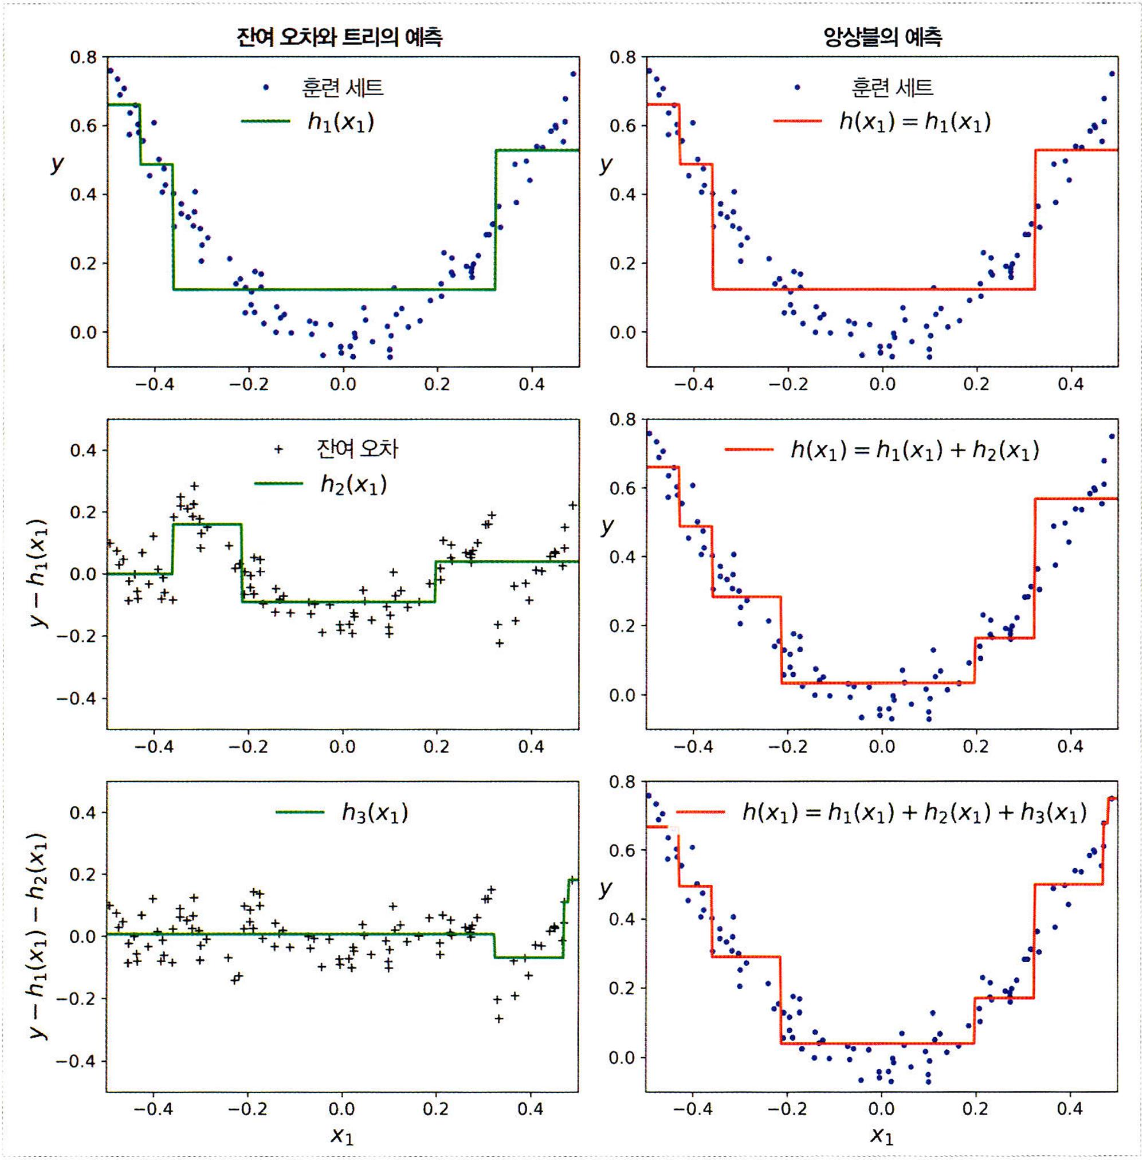

왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측이다. 첫 번째 헹은 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같다. 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있다. 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었다.

In [7]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

**learning_rate** 매개변수는 각 트리의 기여 정도를 조절한다. 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다. 이를 **축소**라고 부른다.

최적의 트리 수를 찾기 위해 조기 종료 기법을 사용할 수 있다. **staged_predict()** 메서드를 사용하면 간단히 구현할 수 있다.

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=np.int64(120))

In [9]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0

for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)

  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up ==5:
      break # 조기종료

실제로 훈련을 중지하는 방법으로 조기 종료를 구현한다. warm_start=True로 설정하면 사이킷런 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다. 위 코드는 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다.

GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수를 지원한다. 이는 편향이 높아지는 대신 분산이 낮아지게 된다. 또한 훈련 속도를 상당히 높인다. 이런 기법을 확률적 그레이디언트 부스팅이라 한다.

In [14]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [13]:
import xgboost

xgb_reg = xgboost.XGBRegressor(early_stopping_rounds=2)

xgb_reg.fit(X_train, y_train,

            eval_set = [(X_val, y_val)])

y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.38293
[1]	validation_0-rmse:0.30394
[2]	validation_0-rmse:0.25673
[3]	validation_0-rmse:0.22674
[4]	validation_0-rmse:0.21115
[5]	validation_0-rmse:0.20328
[6]	validation_0-rmse:0.19397
[7]	validation_0-rmse:0.19381
[8]	validation_0-rmse:0.19441
[9]	validation_0-rmse:0.19105
[10]	validation_0-rmse:0.19088
[11]	validation_0-rmse:0.19078
[12]	validation_0-rmse:0.19110


## 7.6 스태킹

스태킹의 기본 아이디어는 '앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련시킬 수는 없을까'이다.

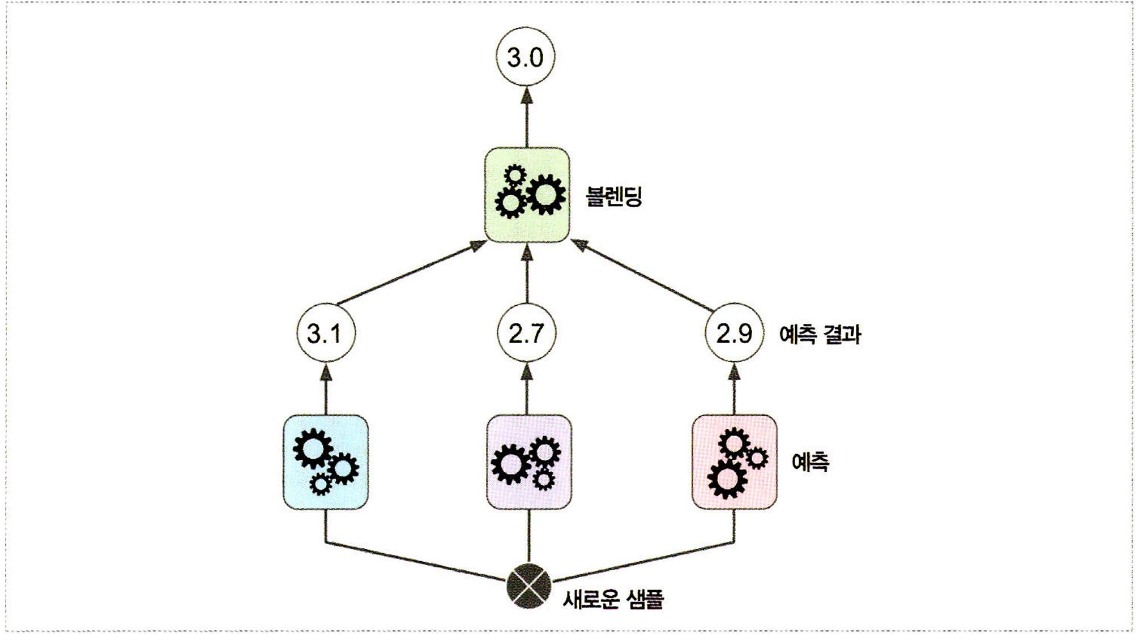

위 그림은 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여준다. 각 예측기는 각각 다른 값을 예측하고 마지막 예측기가 이 예측을 입력받아 최종 예측을 만든다.

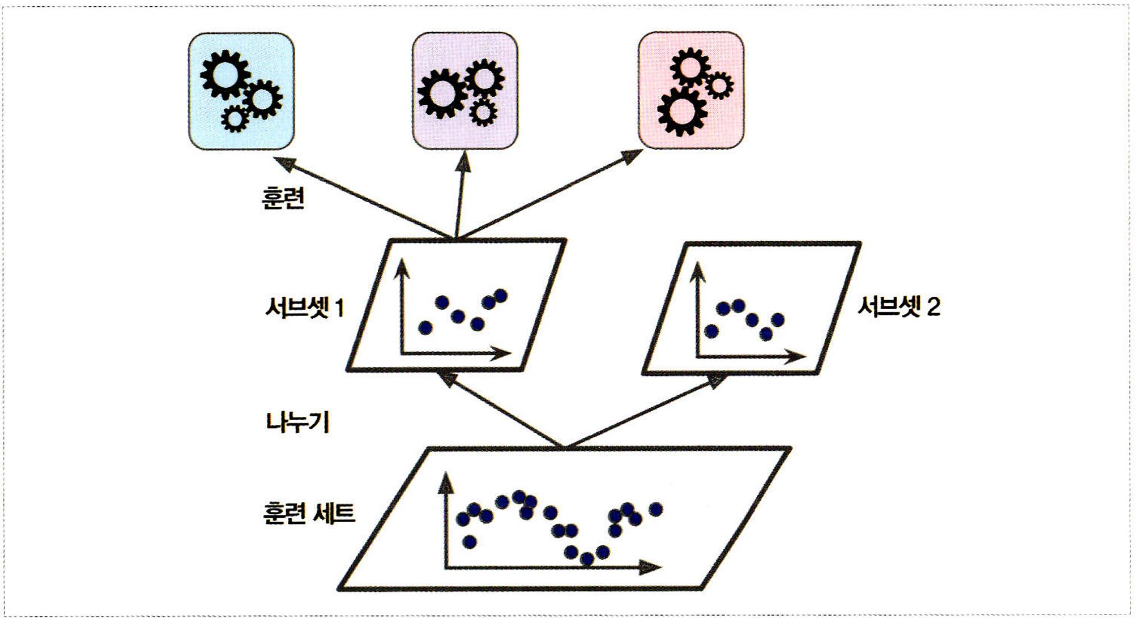

블렌더를 학습시키는 일반적인 방법은 **홀드 아웃 세트**를 사용하는 것이다. 먼저 훈련 세트를 두 개의 서브셋으로 나눈다. 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용된다.

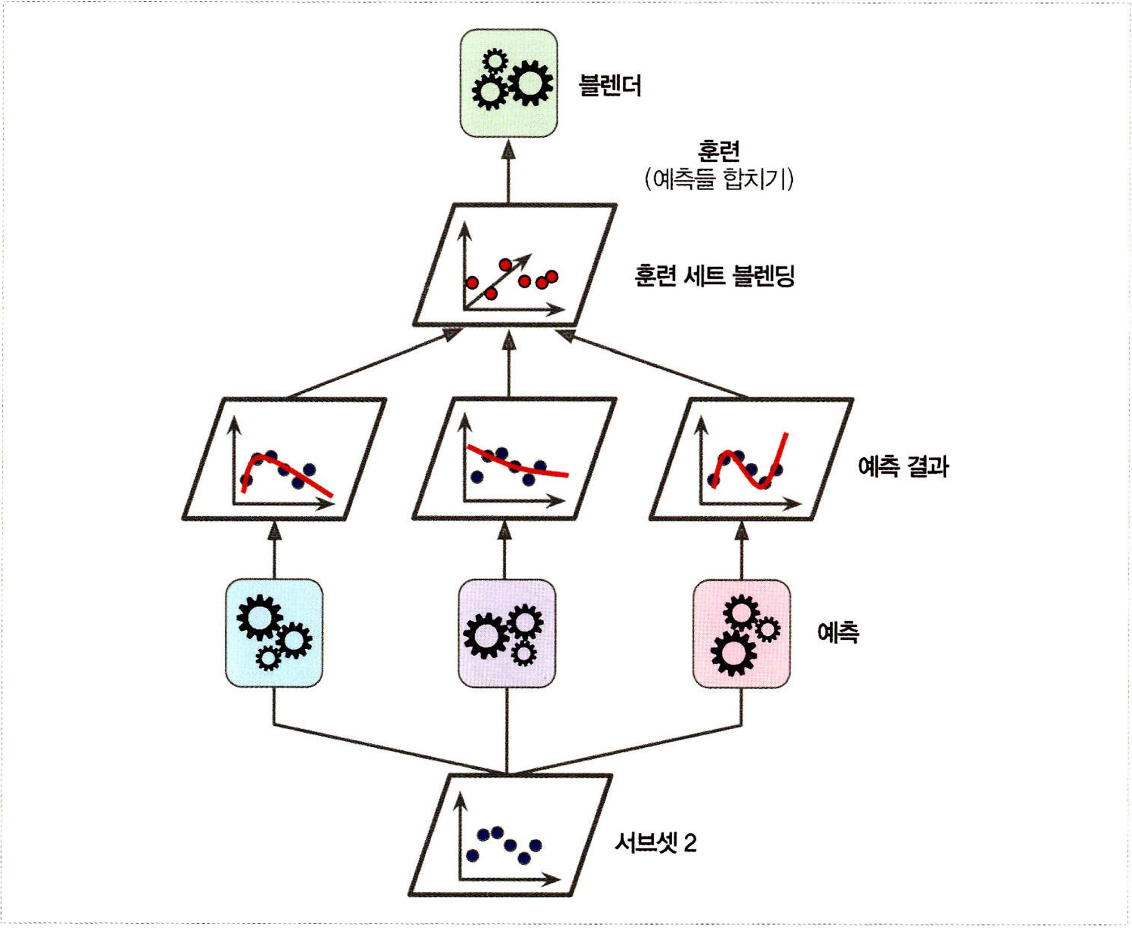


그런 다음 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만든다. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다. 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다. 블렌더가 새 훈련 세트로 훈련된다. 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습된다.

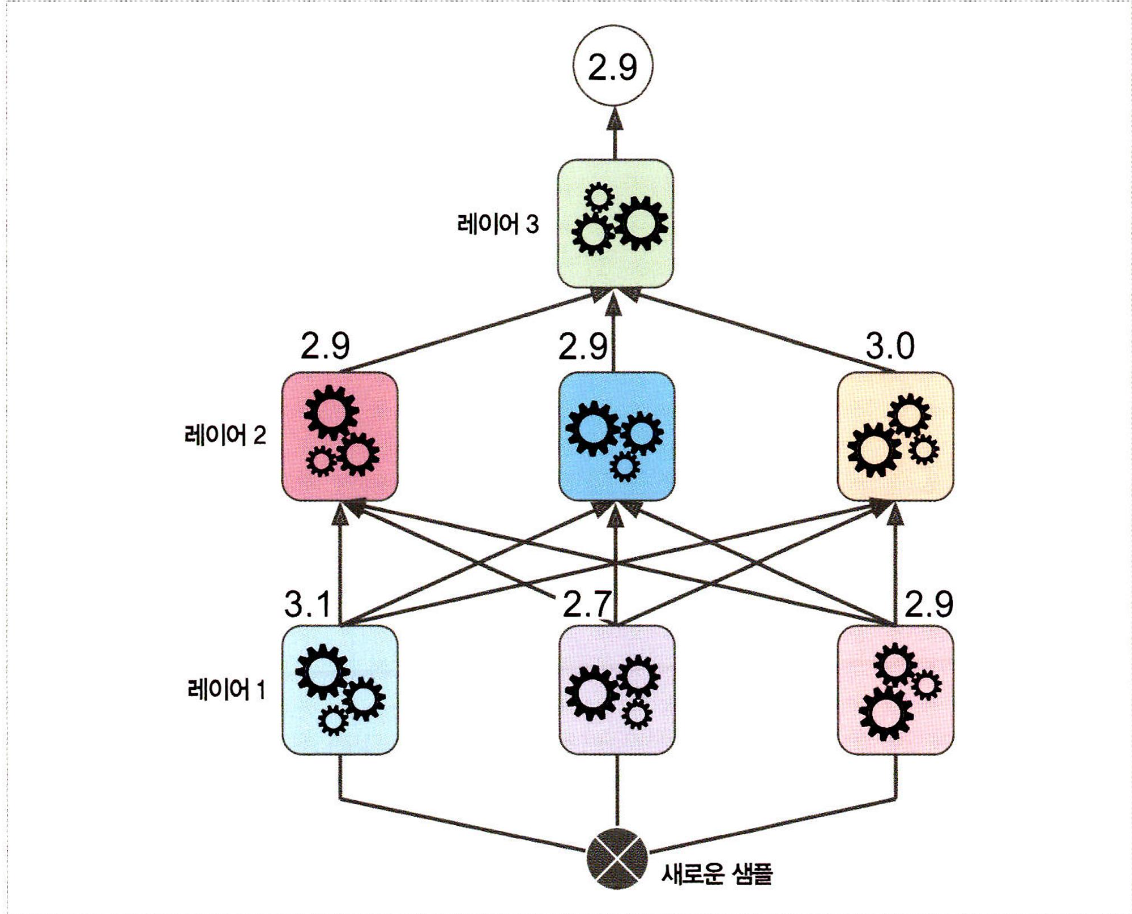

이런 방식의 블렌더를 여러 개 훈련시키는 것도 가능하다. 그러면 블렌더만의 레이어가 만들어진다. 이렇게 하려면 훈련 세트를 3개의 서브셋으로 나눈다. 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용한다. 그리고 세 번째 세트는 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용된다. 작업이 끝나면 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있다.